In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install tensorboard

In [ ]:
import pandas as pd

In [9]:
data_path = r"D:\datasets\cv-corpus-19.0-2024-09-13-fr\cv-corpus-19.0-2024-09-13\fr"
data_path = r"/mnt/d/datasets/cv-corpus-19.0-2024-09-13-fr/cv-corpus-19.0-2024-09-13/fr"

train_age_only = True
use_ordinal_age = False
use_early_stopping = False
features_length = 40

# Hyperparameters
loss_age_weight = 1
loss_genre_weight = 1
learning_rate = 0.1
epochs = 10
batch_size = 64
num_age_classes = 7
train_ratio = 0.90

In [10]:
from sklearn.model_selection import train_test_split


def preprocess_label_data(label_data, keep_age=False):
    gender_dict = {
        'male_masculine': 0,
        'female_feminine': 1
    }
    age_dict = {
        'teens': 0,
        'twenties': 1,
        'thirties': 2,
        'fourties': 3,
        'fifties': 4,
        'sixties': 5,
        'seventies': 6
    }
    label_data = label_data.copy()
    if keep_age:
        serie_age = label_data['age'].copy()
    if use_ordinal_age:
        label_data['age'] = label_data['age'].map(age_dict)
    else:
        label_data = pd.get_dummies(label_data, columns=['age'])
    label_data['gender'] = label_data['gender'].map(gender_dict)
    return pd.concat([label_data, serie_age], axis=1) if keep_age else label_data

In [11]:
import numpy as np
import pandas as pd


def load_csv_data(csv_path):
    """
    Load CSV data into a DataFrame with specific columns.
    """
    df = pd.read_csv(csv_path)
    return df


def create_dataset(csv_path, batch_size, num_age_classes, train_ratio=0.8, random_state=0):
    """
    Create a tf.data.Dataset from a CSV file.
    """
    # Load CSV and preprocess
    df = load_csv_data(csv_path)
    df = preprocess_label_data(df)

    # Split the data
    train_data, val_data = train_test_split(df, train_size=train_ratio, random_state=random_state,
                                            stratify=df['gender'])
    print(f"Train data: {len(train_data)} samples")
    print(f"Validation data: {len(val_data)} samples")
    # Convert columns to tensors
    def convert_to_tensors(data):
        features = tf.convert_to_tensor(data['mfcc_features'].values, dtype=tf.float32)
        ages = tf.convert_to_tensor(data['age'] if use_ordinal_age else data.iloc[:, 3:].values,
                                    dtype=tf.float32)  # Assuming age columns start from index 3
        if not train_age_only:
            genders = tf.convert_to_tensor(data['gender'].values, dtype=tf.int32)
            return features, genders, ages
        else:
            return features, ages

    if not train_age_only:
        train_features, train_genders, train_ages = convert_to_tensors(train_data)
        val_features, val_genders, val_ages = convert_to_tensors(val_data)
        # Create datasets from tensors
        train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_genders, train_ages))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_genders, val_ages))

        # Parse rows, and batch
        train_dataset = (
            train_dataset
            .map(lambda path, gender, age: tf_parse_row(path, gender, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )

        val_dataset = (
            val_dataset
            .map(lambda path, gender, age: tf_parse_row(path, gender, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )
    else:
        train_features, train_ages = convert_to_tensors(train_data)
        val_features, val_ages = convert_to_tensors(val_data)
        # Create datasets from tensors
        train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_ages))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_ages))

        # Parse rows, and batch
        train_dataset = (
            train_dataset
            .map(lambda path, age: tf_parse_row(path, None, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )

        val_dataset = (
            val_dataset
            .map(lambda path, age: tf_parse_row(path, None, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )
    return train_dataset, val_dataset


def tf_parse_row(features, gender_label, age_label, num_age_classes):
    """
    Wrapper to use the parse_row function with TensorFlow.
    """

    # Set shapes for TensorFlow to understand
    features.set_shape([features_length])  # Ajustez cette forme en fonction de vos données
    age_label.set_shape([] if use_ordinal_age else [num_age_classes])
    labels = {"age": age_label}
    if not train_age_only:
        gender_label.set_shape([])
        labels['gender'] = gender_label
    return features, labels




In [12]:
csv_path = f"features.csv"
train_dataset, val_dataset = create_dataset(csv_path, batch_size, num_age_classes, train_ratio)
train_dataset.head()

Train data: 1260 samples
Validation data: 140 samples


NameError: name 'tf' is not defined

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers


class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', activation='relu',
                 kernel_initializer='he_normal', batch_norm=True, max_pool=True, dropout_rate=0.0):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer
        )
        self.conv2 = layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer
        )
        self.batch_norm = layers.BatchNormalization() if batch_norm else None
        self.activation = layers.Activation(activation)
        self.max_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same') if max_pool else None
        self.dropout = layers.Dropout(dropout_rate) if dropout_rate > 0 else None

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        if self.batch_norm:
            x = self.batch_norm(x, training=training)
        x = self.activation(x)
        if self.max_pool:
            x = self.max_pool(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return x


class AudioAgeAndGenderClassifier(tf.keras.Model):
    def __init__(self, input_shape=40):
        super(AudioAgeAndGenderClassifier, self).__init__()
        self.blocks = [
            ConvBlock(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            ConvBlock(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            ConvBlock(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            ConvBlock(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            # ConvBlock(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',
            #           kernel_initializer='he_normal', batch_norm=True, max_pool=True, dropout_rate=0.5),
        ]

        self.reduction_layer = layers.Flatten()
        self.dense = layers.Dense(128, activation='sigmoid')
        self.age_output = layers.Dense(1 if use_ordinal_age else num_age_classes,
                                       activation="relu" if use_ordinal_age else 'softmax')
        if not train_age_only:
            self.gender_output = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = tf.expand_dims(inputs, axis=-1)
        # x = inputs
        for block in self.blocks:
            x = block(x, training=training)

        x = self.reduction_layer(x)
        x = self.dense(x, training=training)
        age_pred = self.age_output(x)

        if not train_age_only:
            gender_pred = self.gender_output(x)
            return {"age": age_pred, "gender": gender_pred}
        else:
            return {"age": age_pred}


# Instantiate the model
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("Using CPU")

2024-12-08 14:24:27.502677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 14:24:27.647941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733664267.719059    4996 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733664267.734898    4996 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 14:24:27.890660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Using GPU: /device:GPU:0


I0000 00:00:1733664270.265171    4996 gpu_device.cc:2022] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def age_loss_function(y_true, y_pred):
    # return tf.reduce_mean(tf.square(y_true / num_age_classes - 1 - y_pred))
    return tf.abs(tf.reduce_mean(y_true / num_age_classes - 1 - y_pred))


# Compile the model
def compile_model(model, learning_rate=0.001):
    # Define separate losses for age and gender
    losses = {
        "age": age_loss_function if use_ordinal_age else tf.keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "age": [tf.keras.metrics.MeanSquaredError() if use_ordinal_age else tf.keras.metrics.CategoricalAccuracy()],
    }
    if not train_age_only:
        losses["gender"] = tf.keras.losses.BinaryCrossentropy()
        metrics["gender"] = [tf.keras.metrics.BinaryAccuracy()]

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=losses,
        loss_weights=[loss_age_weight, loss_genre_weight] if not train_age_only else [loss_age_weight],
        metrics=metrics,
    )
    return model


def plot_confusion_matrix(y_test_classes, y_pred_classes, display_labels, title="Confusion Matrix"):
    if not use_ordinal_age:
        y_test_classes = np.argmax(y_test_classes, axis=1)
        y_pred_classes = np.argmax(y_pred_classes, axis=1)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Optionally normalize the confusion matrix
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    # Plot the matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


def print_example_output(model, dataset):
    predictions_list = []
    labels_list = []
    for batch in dataset:
        features, labels = batch
        # Plot confusion matrix using pyplot
        predictions = model.predict(features)
        predictions_list.append(predictions)
        labels_list.append(labels)

    labels = {key: np.concatenate([label[key] for label in labels_list]) for key in
              labels_list[0].keys()}
    predictions = {key: np.concatenate([pred[key] for pred in predictions_list]) for key in
                   predictions_list[0].keys()}
    plot_confusion_matrix(labels["age"], predictions["age"], np.arange(0, np.max(predictions["age"])),
                          title="Age Confusion Matrix")
    if not train_age_only:
        plot_confusion_matrix(labels["gender"], predictions["gender"], ['male', 'female'],
                              title="Gender Confusion Matrix")


# Train the model
def train_model(model, dataset, validation_dataset, epochs, batch_size, verbose=0):
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_model.keras", save_best_only=True, monitor="val_loss"
        ),
        tf.keras.callbacks.TensorBoard(log_dir="./logs"),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print_example_output(model, val_dataset)
        ),
    ]
    if use_early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=3
            ), )

    # Train the model
    history = model.fit(
        dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history


csv_path = f"{data_path}/validated_filtered_100_per_age.csv"

# csv_path = f"{data_path}/validated_filtered_100.csv"
csv_path = f"{data_path}/features.csv"

train_dataset, val_dataset = create_dataset(csv_path, batch_size, num_age_classes, train_ratio)

Train data: 1260 samples
Validation data: 140 samples


I0000 00:00:1733664295.556381    4996 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


ValueError: could not convert string to float: '[-8.61413086e+02  1.00171486e+02  9.73597908e+00  2.33919487e+01\n  8.27231824e-01 -6.01615810e+00  9.12188911e+00  1.22771430e+00\n -1.43263597e+01  8.49530995e-01 -1.41447961e+00 -5.88370609e+00\n  1.08055580e+00 -3.05928993e+00 -3.21787405e+00 -2.58111286e+00\n -2.73121309e+00 -1.73651266e+00 -7.71248221e-01 -2.65680814e+00\n  5.96841972e-04 -3.66110420e+00 -3.75554776e+00  5.14003932e-01\n -2.37352872e+00 -3.40645432e+00 -3.78667355e+00 -2.99894595e+00\n -1.76282811e+00  5.32053888e-01 -2.00210023e+00 -4.57469797e+00\n -3.62796879e+00 -1.65720928e+00 -8.71657014e-01 -2.15640831e+00\n -2.68343329e+00 -2.19119644e+00 -1.06005609e+00 -1.68563294e+00]'

In [ ]:
# Train the model
model = AudioAgeAndGenderClassifier(input_shape=features_length)
model = compile_model(model, learning_rate)
history = train_model(model, train_dataset, val_dataset, epochs, batch_size, verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - categorical_accuracy: 0.1227 - loss: 5.1091

In [79]:
model.summary()

Model: "audio_age_and_gender_classifier_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_78 (ConvBlock)       │ ?                      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 441344)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │    56,492,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,477,477 (646.51 MB)

 Trainable params: 56,492,481 (215.50 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 112,984,964 (431.00 MB)

Feature shape: (128, 862)


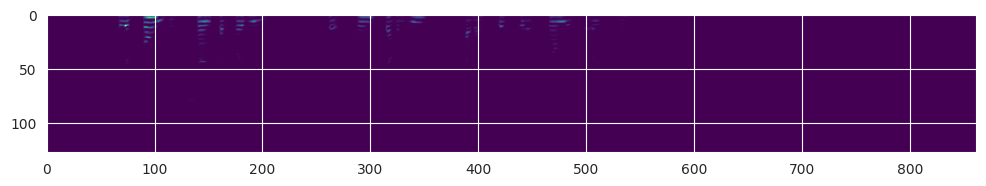

In [22]:
# Visualise a batch on the same figure
import matplotlib.pyplot as plt
features, labels = train_dataset.take(1).as_numpy_iterator().next()
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    if i != 5:
        continue
    print(f"Feature shape: {feature.shape}")
    plt.imshow(feature, cmap='viridis')
plt.show()